In [590]:
%pwd

'/Users/sven/gh/fullstack-ml-academy-homework/notepads/05-Explorative-Datenanalyse'

## Descriptive Statistics

Just listing some concepts.

### Lageparameter
* Arithmetisches Mittel / Durchschnitt / average
* Getrimmtes Mittel / truncated mean
* Gewichtetes Mittel / weighted arithmetic mean
* Median

### Streuungsmaße
* Spannweite / range
* Mittlere Absolute Abweichung / mean absolute deviation
* Varianz / variance
* Standardabweichung / standard deviation
* Quantil, Perzentil, Quartil
* Interquartilsabstand / Spannweite vom Perzentil 25 zum Perzentil 75 / interquartil range
* Variationskoeffizient
* Empirischer Quartilsdispersionskoeffizient

### Verteilungen
* Boxplot
* Histogram
* Dichtediagramm

### Zusammenhangmaße
* Korrelationskoeffizient
* Korrelationsmatrix
* Streudiagramm
* Streudiagramm_Matrix
* Predictive Power Score


In [591]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.patches import Polygon
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from scipy import stats
import ppscore as pps


In [592]:
# in pandas globally set the output format so that floats are rendered with zero fraction digits
# use this with great care since it can easily be misleading
pd.options.display.float_format = '{:.0f}'.format

# read the CSV file
# using separator character semicolon
data = pd.read_csv("../../data/Census-Datensatz.csv", sep=';', skipinitialspace=True)

# make a copy of the read data frame to work on
# just for flexibility if we need to look at the original somewhere
df = data.copy()

# make column names pythonic
# so that they can be used in code where applicable
df.columns = df.columns.str.replace("-", "_")

# drop fnlwgt since many analysts seem to discard it
# as it is not an easily usable weight
df.drop(['fnlwgt'],axis=1,inplace=True)

# cleaning strings in object columns
# in particular removing any leading or trailing whitespace
for i in df.columns:
    if df[i].dtype=='object':
        df[i] = df[i].str.strip()

In [593]:
# take a closer tecnical look at column income
print(f"\n\ndf['income'].dtype={df['income'].dtype}")
print(df['income'])

# add categorial column income_cat
# as a column of pandas data type category
# first define the category in terms of an object of type CategoricalDtype representing the category
income_categories = CategoricalDtype(categories=["<=50K", ">50K"], ordered=True)
# then use the category for the new column called income_cat
df['income_cat'] = df['income'].astype(income_categories)
# take a closer technical look at the new column
print(f"\n\ndf['income_cat'].dtype={df['income_cat'].dtype}")
print(df['income_cat'])

# additionally also add column income_cat_int
# representing the column income_cat using data type integer
income_column = df[['income']].copy()
# obtain automatically assigned numerical codes for the categories
income_column_category_codes = income_column.income.astype('category').cat.codes
# go with int64 instead of int8 just for internal consistency
df['income_cat_int'] = income_column_category_codes.astype('int64')
# take a closer technical look at the new column
print(f"\n\ndf['income_cat_int'].dtype={df['income_cat_int'].dtype}")
print(df['income_cat_int'])



df['income'].dtype=object
0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income, Length: 32561, dtype: object


df['income_cat'].dtype=category
0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income_cat, Length: 32561, dtype: category
Categories (2, object): ['<=50K' < '>50K']


df['income_cat_int'].dtype=int64
0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income_cat_int, Length: 32561, dtype: int64


In [594]:
df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_cat,income_cat_int
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,<=50K,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,<=50K,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,<=50K,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,<=50K,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,<=50K,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,>50K,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,<=50K,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,<=50K,0


In [595]:
df.describe(include='all')

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_cat,income_cat_int
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,NaN,9,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2,2,NaN
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K,<=50K,NaN
freq,NaN,22696,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720,24720,NaN
mean,39,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,1078,87,40,NaN,NaN,NaN,0
std,14,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,7385,403,12,NaN,NaN,NaN,0
min,17,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN,NaN,0
25%,28,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,0,0,40,NaN,NaN,NaN,0
50%,37,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,0,0,40,NaN,NaN,NaN,0
75%,48,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,0,0,45,NaN,NaN,NaN,0


In [596]:
# see how the concept of currying from functional programming (FP) would look like in python
# just out of curiosity
from inspect import signature

# decorator to facilitate currying in python
def curry(fn):
    """
    Decorator to curry any function.

    Parameters
    __________
    f : function
        A function to curry.

    Returns
    _______
    fn(...) : object
        The result or a curried function. Depending on the number of parameters given.
    """
    num_args = len(signature(fn).parameters)
    def init(*args, **kwargs):
      def call(*more_args, **more_kwargs):
        all_args = args + more_args
        all_kwargs = dict(**kwargs, **more_kwargs)
        if len(all_args) + len(all_kwargs) >= num_args:
          return fn(*all_args, **all_kwargs)
        else:
          return init(*all_args, **all_kwargs)
      return call
    return init()

# use of the above decorator
@curry
def as_int(f, x) -> int:
    """
    Effectively int(f(x)).

    Parameters
    __________
    f : function
        A function to call.
    x : object
        Value to pass to the function f as the only parameter.

    Returns
    _______
    int(f(x)) : int
        The result as an int.
    """
    y = f(x)
    return int(y)

def is_greater_than_zero(x: int) -> bool:
    b: bool = x > 0
    return b

# is_greater_than_zero_as_int is a function with the first parameter fixed to is_greater_than_zero
# which is something referred to as a curried function
is_greater_than_zero_as_int = as_int(is_greater_than_zero)

In [597]:
# map the columns capital_gain and capital_loss to int
# via our curried function is_greater_than_zero_as_int
df['capital_gain_present'] = df['capital_gain'].map(is_greater_than_zero_as_int)
df['capital_loss_present'] = df['capital_loss'].map(is_greater_than_zero_as_int)
df = df.assign(capital_gain_and_loss_present=lambda x: x.capital_gain_present & x.capital_loss_present)

In [598]:
# look at the value counts of these columns
# just to check if everything checks out
capital_flags_value_counts = df[['capital_gain_present', 'capital_loss_present', 'capital_gain_and_loss_present']].value_counts()
# note that capital_flags_value_counts is actually a pandas Series object
# and its first three columns are just part of an index
print(capital_flags_value_counts)
# the sum of the series is therefore just 28330 + 2712 + 1519
print(f"\nThe total count computed via pandas value_counts() is: {capital_flags_value_counts.sum()}")

capital_gain_present  capital_loss_present  capital_gain_and_loss_present
0                     0                     0                                28330
1                     0                     0                                 2712
0                     1                     0                                 1519
dtype: int64

The total count computed via pandas value_counts() is: 32561


In [599]:
# call pandas describe requesting some more percentiles that usual
# in particular to inspect columns capital_gain capital_loss hours_per_week
# calso including all sorts of column i.e. not only numeric columns
df.describe(include='all',percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_cat,income_cat_int,capital_gain_present,capital_loss_present,capital_gain_and_loss_present
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,NaN,9,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2,2,NaN,NaN,NaN,NaN
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K,<=50K,NaN,NaN,NaN,NaN
freq,NaN,22696,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720,24720,NaN,NaN,NaN,NaN
mean,39,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,1078,87,40,NaN,NaN,NaN,0,0,0,0
std,14,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,7385,403,12,NaN,NaN,NaN,0,0,0,0
min,17,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN,NaN,0,0,0,0
5%,19,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,0,0,18,NaN,NaN,NaN,0,0,0,0
10%,22,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,0,0,24,NaN,NaN,NaN,0,0,0,0
25%,28,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,0,0,40,NaN,NaN,NaN,0,0,0,0


In [600]:
# retain only some of the numeric columns
# composing an integer data frame
numeric_columns = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
numeric_columns = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
df_numeric = df[numeric_columns]
# sort by age because we can ;-)
df_sorted = df_numeric.sort_values(by='age', ascending=True)
# ensure datatype int32
df_int = df_sorted.astype('int64')
# also stick our column income_cat_int into this integer data frame
df_int['income_cat_int'] = df['income_cat_int'].copy()
# data_int.describe(percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99]).apply('{:.0f}'.format)
# raises error with message unsupported format string passed to Series.__format__
# so instead we use pd.options.display.float_format = '{:.0f}'.format above after importing pandas
df_int.describe(include='all', percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99])

,age,capital_gain,capital_loss,hours_per_week,income_cat_int
count,32561,32561,32561,32561,32561
mean,39,1078,87,40,0
std,14,7385,403,12,0
min,17,0,0,1,0
5%,19,0,0,18,0
10%,22,0,0,24,0
25%,28,0,0,40,0
50%,37,0,0,40,0
75%,48,0,0,45,0
90%,58,0,0,55,1


In [601]:
# average value
print(f"mean\n {df_int.mean(numeric_only=True)}")
# similar to the 50th percentile
print(f"\nmedian\n {df_int.median(numeric_only=True)}")
# the most frequently occuring value
print(f"\nmode\n {df_int.mode(numeric_only=True)}")

mean
 age                39
capital_gain     1078
capital_loss       87
hours_per_week     40
income_cat_int      0
dtype: float64

median
 age              37
capital_gain      0
capital_loss      0
hours_per_week   40
income_cat_int    0
dtype: float64

mode
    age  capital_gain  capital_loss  hours_per_week  income_cat_int
0   36             0             0              40               0


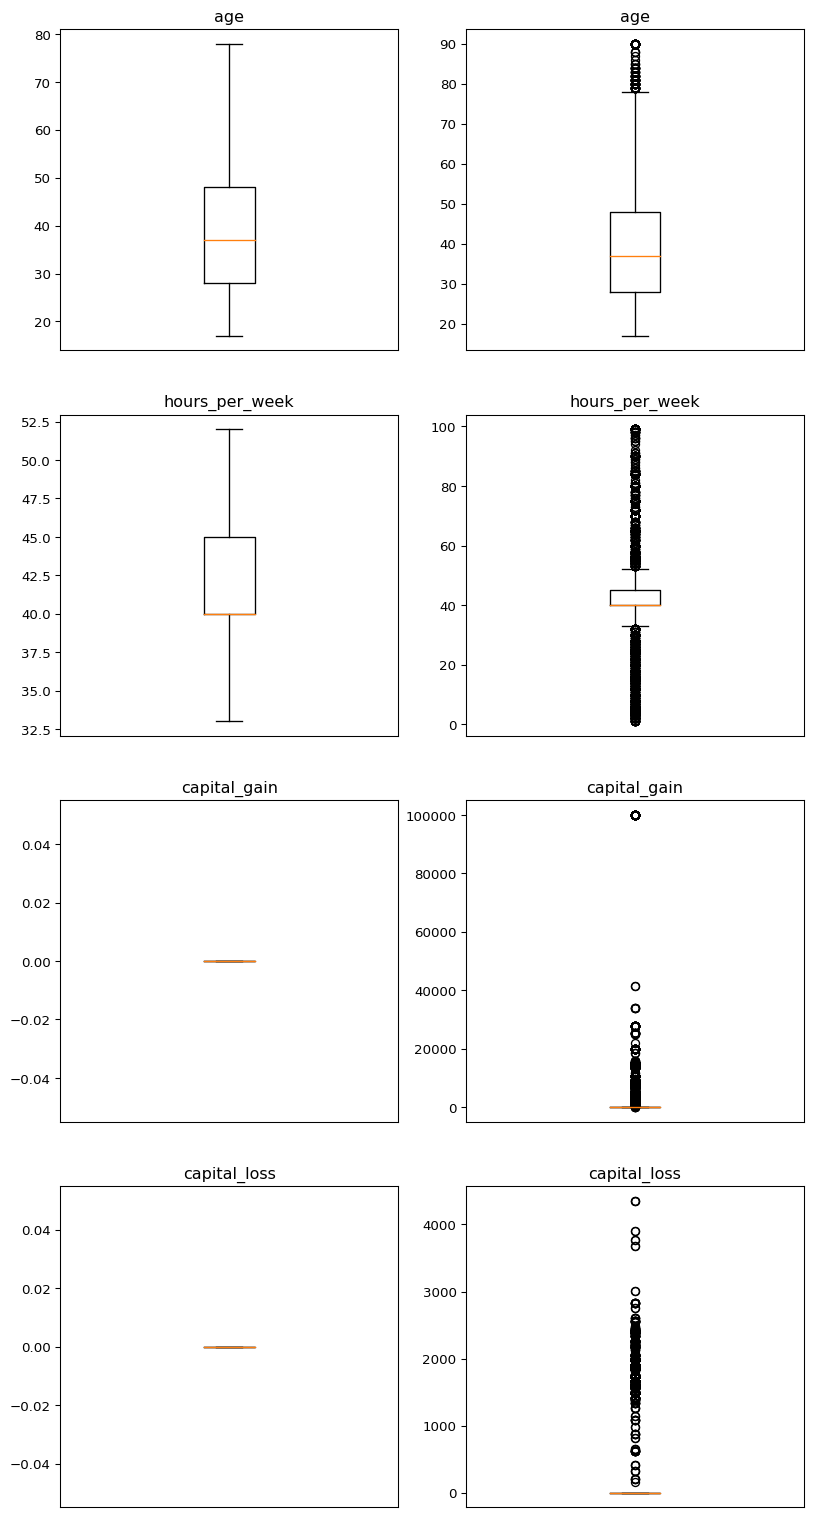

In [602]:
# some box plots
# both without and with showing outliers
fig, axs = plt.subplots(4, 2)

axs[0, 0].boxplot(df_int['age'], showfliers=False)
axs[0, 0].set_title('age')
axs[0, 1].boxplot(df_int['age'], showfliers=True)
axs[0, 1].set_title('age')
axs[1, 0].boxplot(df_int['hours_per_week'], showfliers=False)
axs[1, 0].set_title('hours_per_week')
axs[1, 1].boxplot(df_int['hours_per_week'], showfliers=True)
axs[1, 1].set_title('hours_per_week')
axs[2, 0].boxplot(df_int['capital_gain'], showfliers=False)
axs[2, 0].set_title('capital_gain')
axs[2, 1].boxplot(df_int['capital_gain'], showfliers=True)
axs[2, 1].set_title('capital_gain')
axs[3, 0].boxplot(df_int['capital_loss'], showfliers=False)
axs[3, 0].set_title('capital_loss')
axs[3, 1].boxplot(df_int['capital_loss'], showfliers=True)
axs[3, 1].set_title('capital_loss')

for ax in axs.ravel():
    #ax.set_xticks([])
    ax.xaxis.set_major_locator(plt.NullLocator())

fig.set_size_inches(10.0, 20.0)
fig.set_dpi(96.0)


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='capital_gain', ylabel='age'>,
        <Axes: xlabel='capital_loss', ylabel='age'>,
        <Axes: xlabel='hours_per_week', ylabel='age'>,
        <Axes: xlabel='income_cat_int', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='capital_gain'>,
        <Axes: xlabel='capital_gain', ylabel='capital_gain'>,
        <Axes: xlabel='capital_loss', ylabel='capital_gain'>,
        <Axes: xlabel='hours_per_week', ylabel='capital_gain'>,
        <Axes: xlabel='income_cat_int', ylabel='capital_gain'>],
       [<Axes: xlabel='age', ylabel='capital_loss'>,
        <Axes: xlabel='capital_gain', ylabel='capital_loss'>,
        <Axes: xlabel='capital_loss', ylabel='capital_loss'>,
        <Axes: xlabel='hours_per_week', ylabel='capital_loss'>,
        <Axes: xlabel='income_cat_int', ylabel='capital_loss'>],
       [<Axes: xlabel='age', ylabel='hours_per_week'>,
        <Axes: xlabel='capital_gain', ylabel='hours_per_week'>,
        

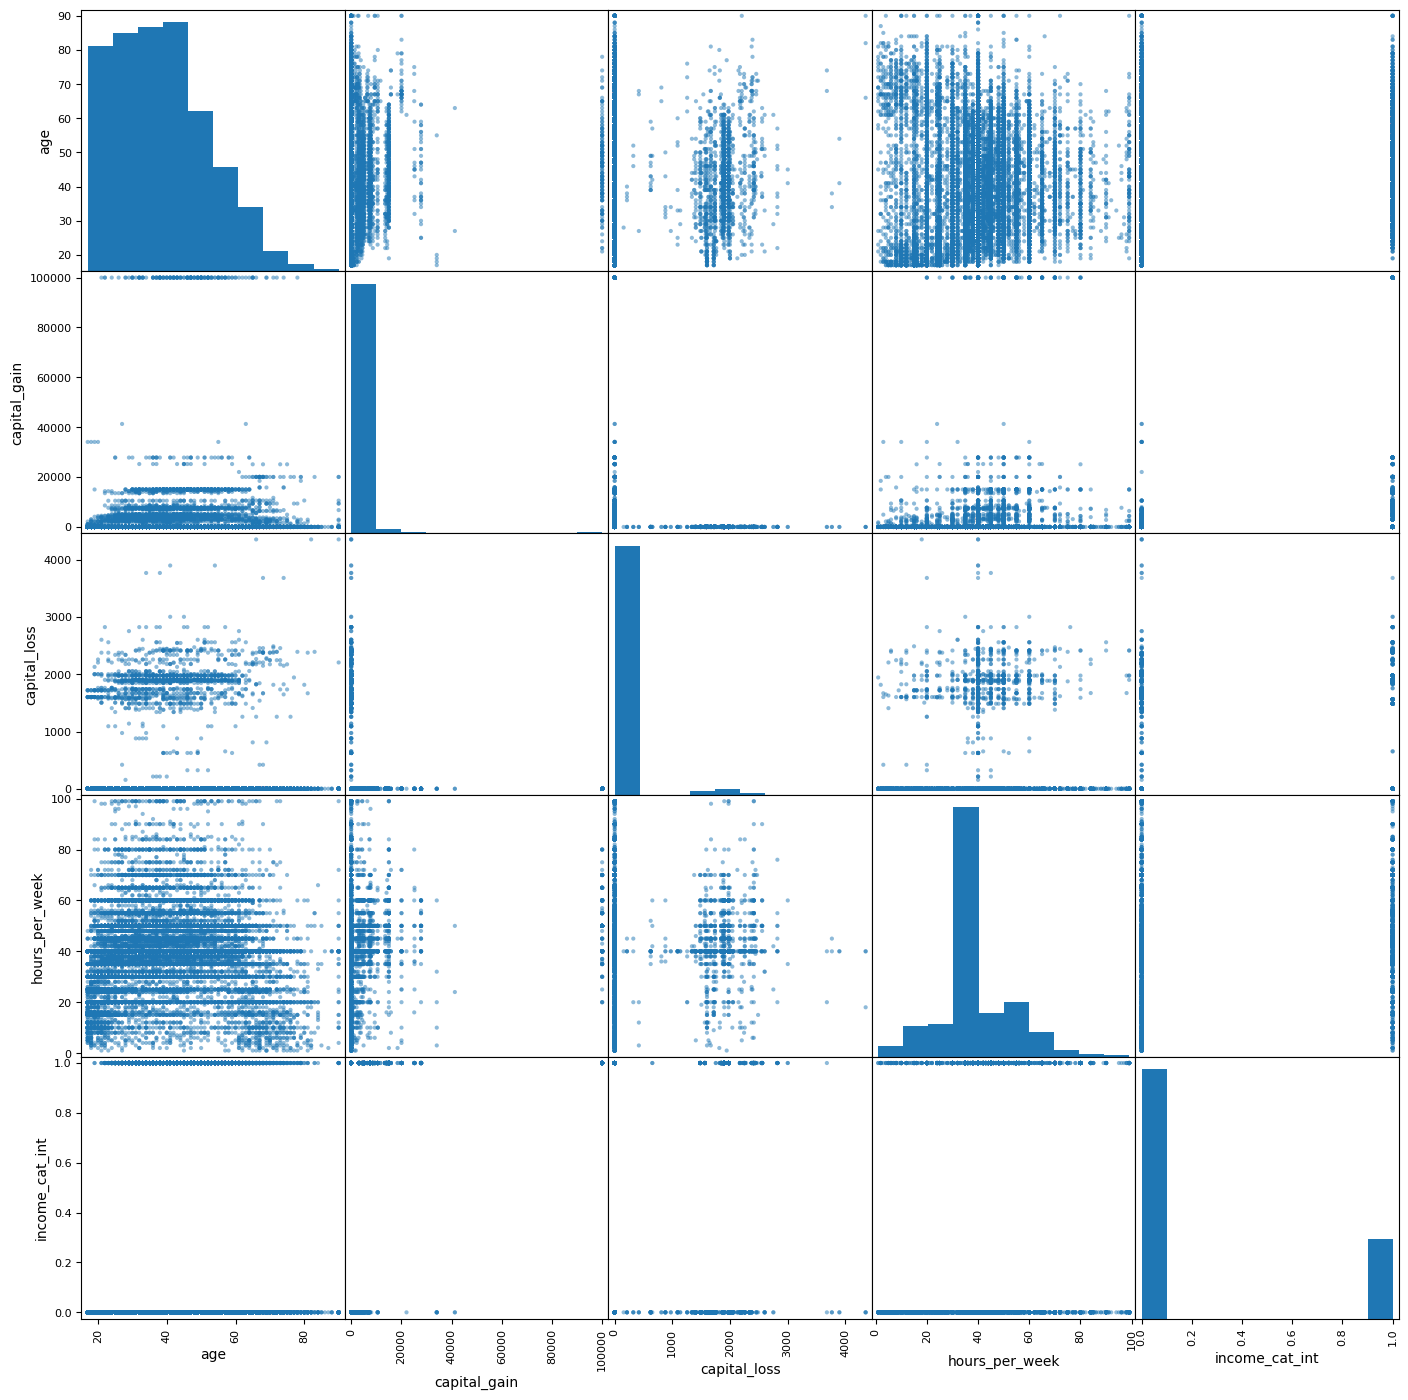

In [603]:
# practical matrix-like arrangement of scatter plots
# with histograms along the diagonal
pd.plotting.scatter_matrix(df_int, 
                           figsize=(17, 17),
                           diagonal = 'hist')

## Insights

### hours_per_week over age
* Diverse hours per week up to 35 are more common among young and old people.
* However, e.g. exactly 20 hours per week as part_time work seems common across all age groups.

### capital_gain and capital_loss over age
* Capital gain appears to be almost independent from age.
* However, enjoying higher capital gains is more likely for people over 25 years.

### capital_loss over age
* Older people experience slightly more often higher capital losses.

### income_cat over age
* Income category >50K is more likely for people over 25 years.

### age histogram
* Many people retire between 50 and 70 years of age.


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='capital_gain', ylabel='age'>,
        <Axes: xlabel='capital_loss', ylabel='age'>,
        <Axes: xlabel='hours_per_week', ylabel='age'>,
        <Axes: xlabel='income_cat_int', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='capital_gain'>,
        <Axes: xlabel='capital_gain', ylabel='capital_gain'>,
        <Axes: xlabel='capital_loss', ylabel='capital_gain'>,
        <Axes: xlabel='hours_per_week', ylabel='capital_gain'>,
        <Axes: xlabel='income_cat_int', ylabel='capital_gain'>],
       [<Axes: xlabel='age', ylabel='capital_loss'>,
        <Axes: xlabel='capital_gain', ylabel='capital_loss'>,
        <Axes: xlabel='capital_loss', ylabel='capital_loss'>,
        <Axes: xlabel='hours_per_week', ylabel='capital_loss'>,
        <Axes: xlabel='income_cat_int', ylabel='capital_loss'>],
       [<Axes: xlabel='age', ylabel='hours_per_week'>,
        <Axes: xlabel='capital_gain', ylabel='hours_per_week'>,
        

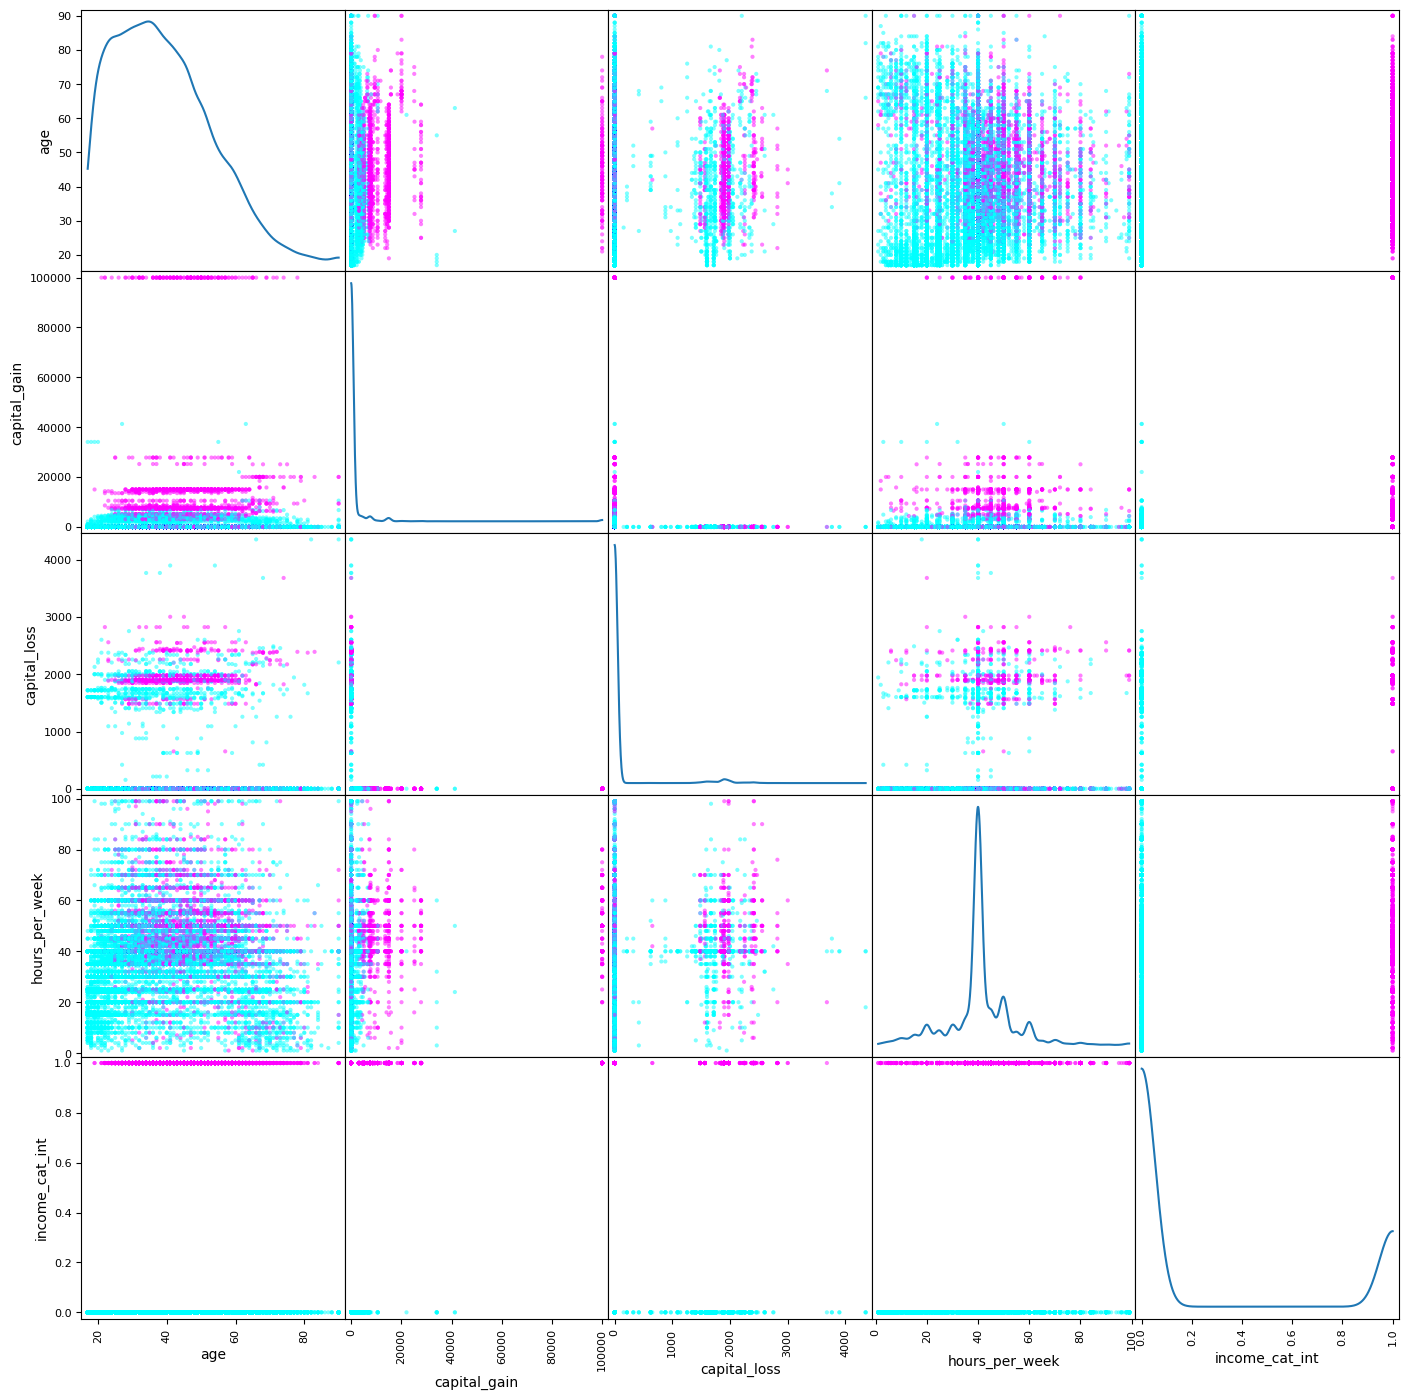

In [604]:
# practical matrix-like arrangement of scatter plots
# with density lines along the diagonal
# and with color range selected via income_cat_int value
pd.plotting.scatter_matrix(df_int, 
                           c=df_int['income_cat_int'], 
                           figsize=(17, 17),
                           cmap = cm['cool'],
                           diagonal = 'kde')

## Insights

### hours_per_week over age colored by income_cat
* Income category >50K is more likely for peopke with 40 or more hours per week.

### hours_per_week distribution function
* 40 hours per week are predominant.


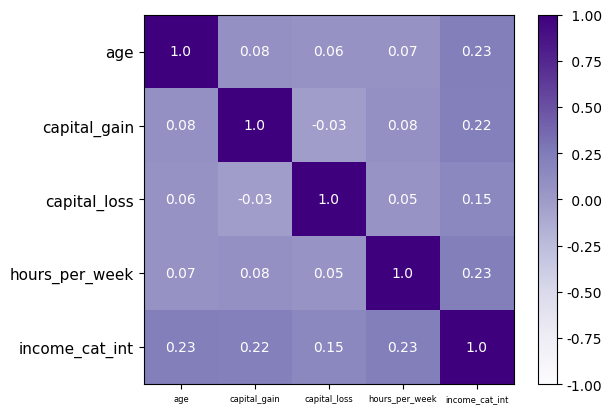

In [605]:
# Pearson product_moment correlation coefficients via pandas
pd.options.display.float_format = '{:.2f}'.format
pd_correlation_matrix = df_int.astype(dtype=float, copy=True).corr(method='pearson', numeric_only=True)
#print(pd_correlation_matrix)
pd.options.display.float_format = '{:.0f}'.format

# basically the same but faster via numpy
npdf = df_int.to_numpy()
np_correlation_matrix = np.corrcoef(npdf, rowvar=False).round(decimals=2)

# visualize the linear correlation matrix obtained via numpy using matplotlib
fig, ax = plt.subplots()
im = ax.imshow(np_correlation_matrix, cmap='Purples')
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=('age', 'capital_gain', 'capital_loss', 'hours_per_week', 'income_cat_int'))
ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=('age', 'capital_gain', 'capital_loss', 'hours_per_week', 'income_cat_int'))
ax.tick_params(axis='x', which='major', labelsize=6)
ax.tick_params(axis='x', which='minor', labelsize=5)
ax.tick_params(axis='y', which='major', labelsize=11)
ax.tick_params(axis='y', which='minor', labelsize=10)
ax.set_ylim(4.5, -0.5)
for i in range(5):
    for j in range(5):
        ax.text(j, i, np_correlation_matrix[i, j], ha='center', va='center',
                color='white')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()


## Insights

### correlation matrix
* Only week linear correlations present in our consensus sample.
* It would be hard to predict the income category using some plain linear regression.

In [606]:
# try out pandas sample covariance matrix
# just out of curiosity
pd_covariance_matrix = df_int.astype(dtype=float, copy=True).cov(numeric_only=True)
pd_covariance_matrix

,age,capital_gain,capital_loss,hours_per_week,income_cat_int
age,186,7825,318,12,1
capital_gain,7825,54542539,-94086,7150,705
capital_loss,318,-94086,162377,270,26
hours_per_week,12,7150,270,152,1
income_cat_int,1,705,26,1,0


## Insights

Disclaimer: The sample mean and sample covariance are not robust statistics, meaning that they are sensitive to outliers.

### sample covariance matrix
* The negative covariance between capital gain and capital loss supposedly tells us that higher capital gains come along with lower capital losses.


In [607]:
# in this out-commented useless example ppscore chooses to use DecisionTreeRegressor
# because all columns are of some numeric data type
# this however yields bad ppscore results
# see next code block for the actual solution
#predictive_power_score_matrix = pps.matrix(df_int.astype(float), output='df')
#predictive_power_score_matrix.style.background_gradient(cmap='twilight', low=0.0, high=1.0)

In [608]:
# here we let ppscore compute against the target income_cat
# the library thus uses DecisionTreeClassifier and the ppscore results make sense
predictive_power_score_matrix_all = pps.predictors(df, y='income_cat', output='df')
predictive_power_score_matrix_all.style.background_gradient(cmap='twilight', low=0.0, high=1.0)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,income,income_cat,1.000000,classification,True,weighted F1,0.653115,1.000000,DecisionTreeClassifier()
1,income_cat_int,income_cat,1.000000,classification,True,weighted F1,0.653115,1.000000,DecisionTreeClassifier()
2,capital_gain,income_cat,0.297123,classification,True,weighted F1,0.653115,0.756183,DecisionTreeClassifier()
3,capital_gain_present,income_cat,0.244023,classification,True,weighted F1,0.653115,0.737763,DecisionTreeClassifier()
4,education,income_cat,0.243135,classification,True,weighted F1,0.653115,0.737455,DecisionTreeClassifier()
5,education_num,income_cat,0.243135,classification,True,weighted F1,0.653115,0.737455,DecisionTreeClassifier()
6,capital_loss,income_cat,0.141755,classification,True,weighted F1,0.653115,0.702288,DecisionTreeClassifier()
7,workclass,income_cat,0.094056,classification,True,weighted F1,0.653115,0.685742,DecisionTreeClassifier()
8,occupation,income_cat,0.092410,classification,True,weighted F1,0.653115,0.685171,DecisionTreeClassifier()
9,capital_loss_present,income_cat,0.079720,classification,True,weighted F1,0.653115,0.680769,DecisionTreeClassifier()


In [609]:
# finally we take look at the full pps matrix
# based on the full data frame with all columns
predictive_power_score_matrix_all = pps.matrix(df, output='df')
predictive_power_score_matrix_all.style.background_gradient(cmap='twilight', low=0.0, high=1.0)

/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/s

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,age,age,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,age,workclass,0.011232,classification,True,weighted F1,0.579088,0.583816,DecisionTreeClassifier()
2,age,education,0.052315,classification,True,weighted F1,0.201200,0.242989,DecisionTreeClassifier()
3,age,education_num,0.000000,regression,True,mean absolute error,1.853000,1.898306,DecisionTreeRegressor()
4,age,marital_status,0.298118,classification,True,weighted F1,0.343600,0.539285,DecisionTreeClassifier()
5,age,occupation,0.027007,classification,True,weighted F1,0.103800,0.128004,DecisionTreeClassifier()
6,age,relationship,0.199205,classification,True,weighted F1,0.268000,0.413818,DecisionTreeClassifier()
7,age,race,0.000000,classification,True,weighted F1,0.783630,0.783630,DecisionTreeClassifier()
8,age,sex,0.000000,classification,True,weighted F1,0.567200,0.555548,DecisionTreeClassifier()
9,age,capital_gain,0.000000,regression,True,mean absolute error,1093.884000,2003.391960,DecisionTreeRegressor()
